In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import six
%matplotlib inline
plt.style.use('ggplot')

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
def render_mpl_table(data, col_width=4.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, rowLabels=data.index, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
            
    return fig, ax

In [7]:
data = pd.read_csv('../data/bigfoot_data.csv', sep='\t', index_col=0)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4807 entries, 0 to 4806
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   4807 non-null   int64 
 1   YEAR                 4799 non-null   object
 2   SEASON               4799 non-null   object
 3   MONTH                4181 non-null   object
 4   STATE                4540 non-null   object
 5   COUNTY               4540 non-null   object
 6   LOCATION DETAILS     4045 non-null   object
 7   NEAREST TOWN         4440 non-null   object
 8   NEAREST ROAD         4078 non-null   object
 9   OBSERVED             4763 non-null   object
 10  ALSO NOTICED         3164 non-null   object
 11  OTHER WITNESSES      4322 non-null   object
 12  OTHER STORIES        3372 non-null   object
 13  TIME AND CONDITIONS  4292 non-null   object
 14  ENVIRONMENT          4517 non-null   object
 15  submitted_date       4799 non-null   object
 16  DATE  

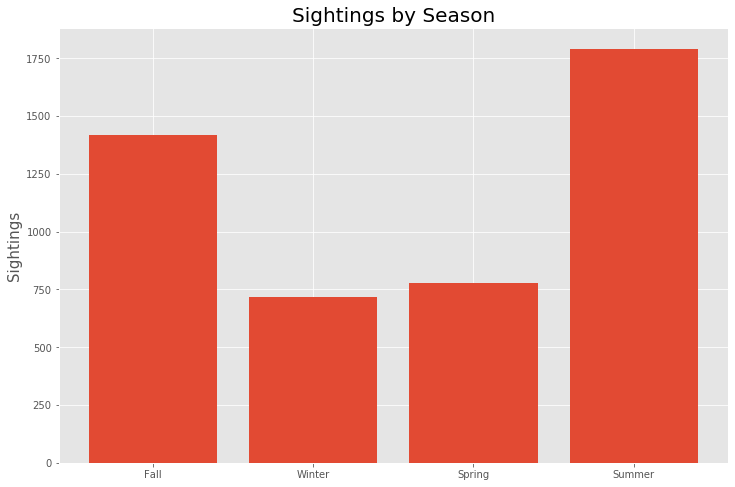

In [64]:
seasons = data.groupby('SEASON').count()['id']
fig, ax = plt.subplots(figsize=(12,8))
s = ['Fall','Winter','Spring','Summer']
ax.bar(s, seasons[s]);
ax.set_title('Sightings by Season', fontsize=20);
ax.set_ylabel('Sightings', fontsize=15);
fig.savefig('../images/season_bar_er.png')

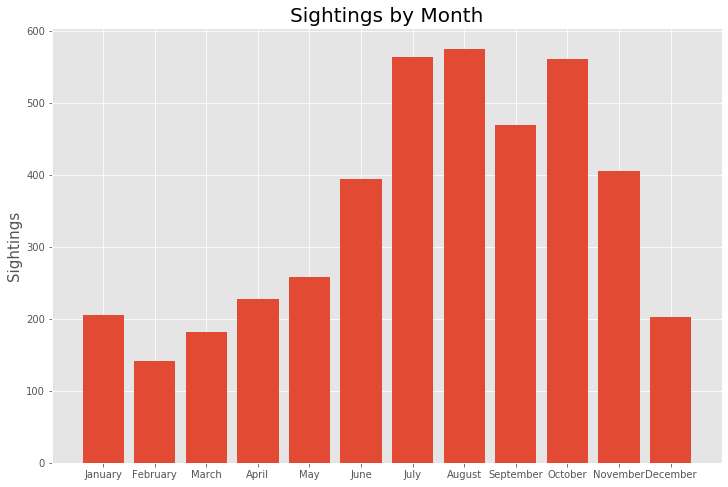

In [65]:
months = data.groupby('MONTH').count()['id']
fig, ax = plt.subplots(figsize=(12,8))
m = ['January','February','March','April','May','June','July','August','September','October','November','December']
ax.bar(m, months[m]);
ax.set_title('Sightings by Month', fontsize=20);
ax.set_ylabel('Sightings', fontsize=15);
fig.savefig('../images/month_bar_er.png')

In [66]:
def tryconvert(x):
    try:
        x = int(str(x[:4]))
    except:
        x = np.nan
    if x > 1000:
        return x
    else:
        return np.nan

data['YEAR'] = data['YEAR'].apply(lambda x: tryconvert(x))

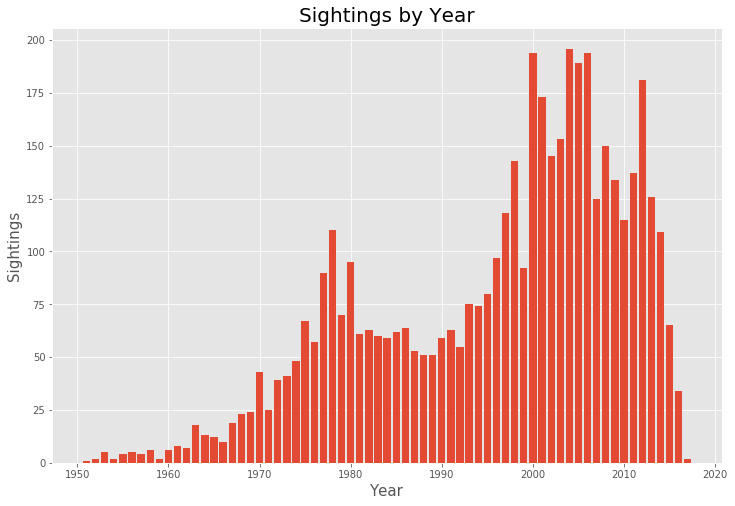

In [72]:
year = data.groupby('YEAR').count()['id']
year = year[year.index > 1950]
fig, ax = plt.subplots(figsize=(12,8))
ax.bar(year.index, year.values);
ax.set_title('Sightings by Year', fontsize=20);
ax.set_ylabel('Sightings', fontsize=15);
ax.set_xlabel('Year', fontsize=15)
fig.savefig('../images/year_bar_er.png')

In [76]:
def tryconvert2(x):
    try:
        x = int(str(x)[-4:])
    except:
        x = np.nan
    return x

data['submit_year'] = data['submitted_date'].apply(lambda x: tryconvert2(x))

In [78]:
data['submit_diff'] = data['submit_year'] - data['YEAR']

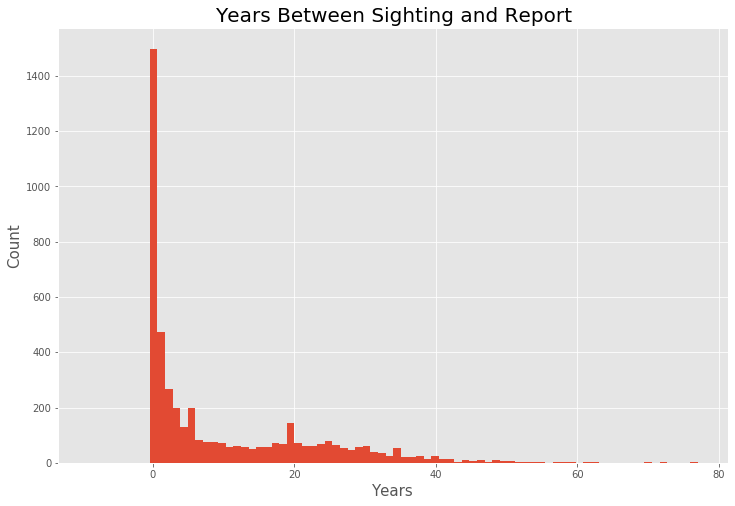

In [89]:
diff = data['submit_diff']
diff = diff[diff < 80]
fig, ax = plt.subplots(figsize=(12,8))
ax.hist(diff.values, bins=80);
ax.set_title('Years Between Sighting and Report', fontsize=20);
ax.set_ylabel('Count', fontsize=15);
ax.set_xlabel('Years', fontsize=15)
fig.savefig('../images/diff_year_hist_er.png')

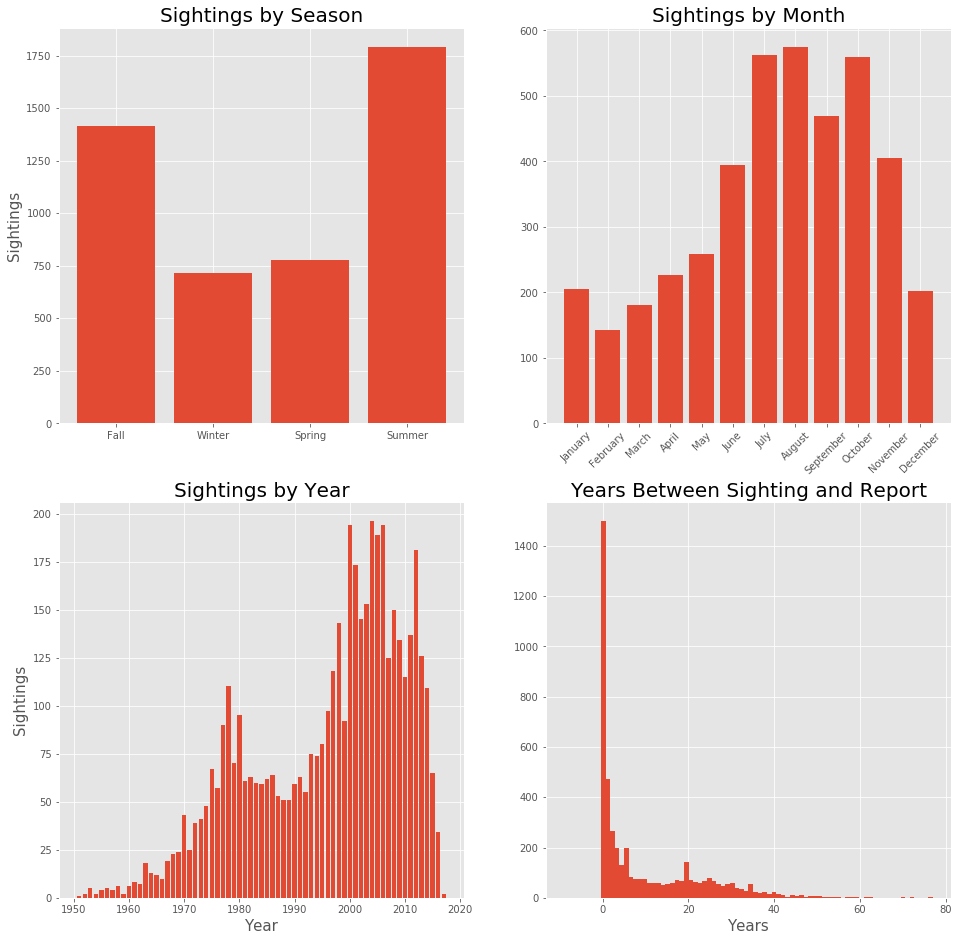

In [172]:
fig, ax = plt.subplots(2,2, figsize=(16,16))
ax = ax.flatten()
ax[0].bar(s, seasons[s]);
ax[0].set_title('Sightings by Season', fontsize=20);
ax[0].set_ylabel('Sightings', fontsize=15);

ax[1].bar(m, months[m]);
ax[1].set_title('Sightings by Month', fontsize=20);
for tick in ax[1].get_xticklabels():
        tick.set_rotation(45)

ax[2].bar(year.index, year.values);
ax[2].set_title('Sightings by Year', fontsize=20);
ax[2].set_ylabel('Sightings', fontsize=15);
ax[2].set_xlabel('Year', fontsize=15)

ax[3].hist(diff.values, bins=80);
ax[3].set_title('Years Between Sighting and Report', fontsize=20);
ax[3].set_xlabel('Years', fontsize=15)

fig.savefig('../images/subplot_er.png', bbox_inches='tight')

## NLP

In [9]:
data['text']

0       I and two of my friends were bored one night s...
1       Me and a couple of friends had been bored, whe...
2       My hunting buddy and I were sitting on a ridge...
3       To whom it may concern, I am a commercial fish...
4       My hiking partner and I arrived late to the Ke...
                              ...                        
4802    Well I had camped in Cypress Hills Interprovin...
4803    I came across your website from following a li...
4804    This incident happened in the summer of 1992 i...
4805    I was about 14 years old, when me and my frien...
4806    The sighting occurred along the Yukon River - ...
Name: text, Length: 4807, dtype: object

In [10]:
cv = CountVectorizer()
cv_fit=cv.fit_transform(data['text'])

vocab_cv = cv.get_feature_names()
vocab_count = cv_fit.toarray().sum(axis=0)

In [11]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(data['text'])
vocab = np.array(sorted(tfidf.vocabulary_))
V = tfidf_matrix

### Clustering

In [12]:
cluster = KMeans(n_clusters=6)
cluster.fit(tfidf_matrix)
centroids = cluster.cluster_centers_

In [13]:
for idx, topic in enumerate(centroids):
    print(vocab[np.argsort(-topic)[:10]])

['river' 'heard' 'area' 'just' 'bridge' 'like' 'fishing' 'saw' 'water'
 'bank']
['road' 'saw' 'car' 'driving' 'just' 'creature' 'area' 'like' 'looked'
 'highway']
['area' 'saw' 'like' 'just' 'tree' 'heard' 'creature' 'woods' 'creek'
 'seen']
['tracks' 'prints' 'snow' 'print' 'foot' 'track' 'area' 'inches' 'road'
 'trail']
['heard' 'sound' 'camp' 'lake' 'tent' 'like' 'night' 'area' 'trail' 'just']
['house' 'heard' 'woods' 'night' 'like' 'window' 'dogs' 'dog' 'just'
 'outside']


In [14]:
labels = np.array(['Seen','Tracks','Driving','Heard','House','Seen'])

In [15]:
report_label = labels[np.argmin(cluster.transform(tfidf_matrix), axis=1)]

In [16]:
data['label_clustering'] = report_label

### NMF

In [134]:
nmf = NMF(n_components=6)
nmf.fit(V)
W = nmf.transform(V)
H = nmf.components_

In [141]:
for idx, topic in enumerate(H):
    print(vocab[np.argsort(-topic)[:15]])

['river' 'tree' 'just' 'deer' 'saw' 'like' 'woods' 'got' 'hunting'
 'looked' 'friend' 'trees' 'started' 'walking' 'thought']
['heard' 'sound' 'sounds' 'night' 'camp' 'sounded' 'area' 'like' 'loud'
 'tent' 'scream' 'noise' 'hear' 'howl' 'forest']
['house' 'window' 'woods' 'door' 'night' 'dogs' 'dog' 'outside' 'said'
 'yard' 'home' 'went' 'brother' 'ran' 'like']
['tracks' 'snow' 'prints' 'print' 'inches' 'trail' 'track' 'foot' 'area'
 'creek' 'footprints' 'toes' 'large' 'pictures' 'size']
['road' 'car' 'creature' 'saw' 'driving' 'highway' 'area' 'tall' 'hair'
 'just' 'sighting' 'right' 'miles' 'dark' 'north']
['lake' 'fishing' 'camp' 'shore' 'boat' 'tent' 'water' 'trail' 'forest'
 'rocks' 'camping' 'rock' 'bear' 'fish' 'son']


In [173]:
labels = np.array(['Witnessed','Heard','Found Tracks','Saw from House','While Driving','While Camping'])

In [174]:
report_label = labels[np.argmax(W, axis=1)]


In [175]:
data['label_NMF'] = report_label

In [268]:
nmf.reconstruction_err_

66.55945190618638

## More EDA with labels

In [176]:
data.head()

,id,YEAR,SEASON,MONTH,STATE,COUNTY,LOCATION DETAILS,NEAREST TOWN,NEAREST ROAD,OBSERVED,ALSO NOTICED,OTHER WITNESSES,OTHER STORIES,TIME AND CONDITIONS,ENVIRONMENT,submitted_date,DATE,text,label_NMF,label_clustering
0,13038,2004,Winter,February,Alaska,Anchorage County,Up near powerline clearings east of Potter Mar...,Anchorage / Hillside,No real roads in the area,I and two of my friends were bored one night s...,"Some tracks in the snow, and a clearing in the...",My two friends were snowmachining behind me bu...,I have not heard of any other incidents in Anc...,Middle of the night. The only light was the he...,"In the middle of the woods, in a clearing cove...",November-12-2005,NaN,I and two of my friends were bored one night s...,Saw from House,Tracks
1,8792,2003,Winter,December,Alaska,Anchorage County,"Few houses on the way, a power relay station. ...",Anchorage,Dowling,"Me and a couple of friends had been bored, whe...","We smelled of colonge and after shave, and one...","4. Me, w-man, warren and sean. We were at my h...",no,"Started at 11, ended at about 3-3:30. Weather ...","A pine forest, with a bog or swamp on the righ...",June-3-2004,Friday night,"Me and a couple of friends had been bored, whe...",Witnessed,House
2,1255,1998,Fall,September,Alaska,Bethel County,"45 miles by air west of Lake Iliamna, Alaska i...",NaN,NaN,My hunting buddy and I were sitting on a ridge...,nothing unusual,Scouting for caribou with high quality binoculars,NaN,NaN,Call Iliamna Air taxi for lat & Long of Long L...,October-5-1999,3,My hunting buddy and I were sitting on a ridge...,Witnessed,Seen
3,11616,2004,Summer,July,Alaska,Bristol Bay County,"Approximately 95 miles east of Egegik, Alaska....",Egegik,NaN,"To whom it may concern, I am a commercial fish...",Just these foot prints and how obvious it was ...,"One other witness, and he was fishing prior to...","I've only heard of one other story, from an ol...","Approximately 12:30 pm, partially coudy/sunny.","Lake front,creek spit, gravel and sand, alder ...",May-6-2005,20,"To whom it may concern, I am a commercial fish...",Saw from House,Tracks
4,637,2000,Summer,June,Alaska,Cordova-McCarthy County,"On the main trail toward the glacier, before t...","Kennikot, Alaska",not sure,My hiking partner and I arrived late to the Ke...,I did hear what appeared to be grunting in the...,"I was the only witness, there was one other in...",None,About 12:00 Midnight / full moon / clear / dim...,This sighting was located at approximately 1 t...,November-13-2000,16,My hiking partner and I arrived late to the Ke...,Witnessed,Seen


In [177]:
np.mean(data['label_NMF'] == data['label_clustering'])

0.16663199500728104

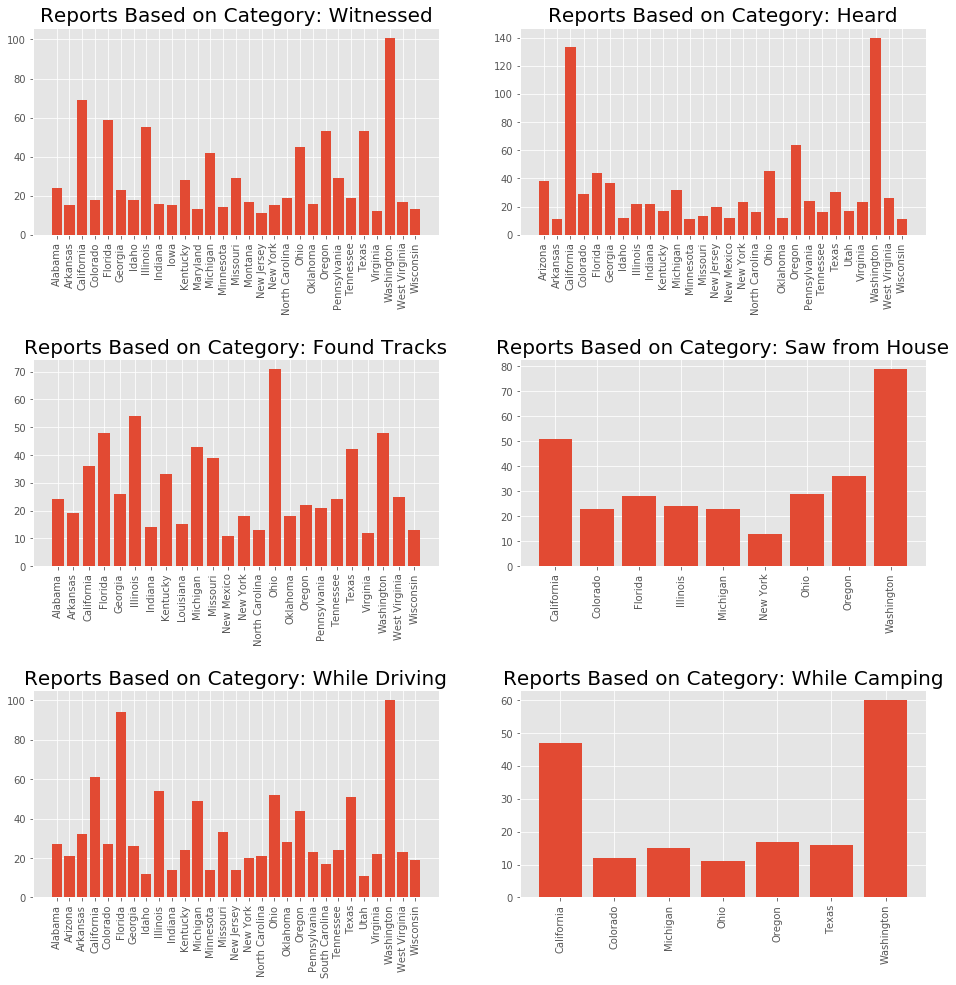

In [178]:
fig, axs = plt.subplots(3,2, figsize=(16,16))
plt.subplots_adjust(hspace=0.6)
for idx, ax in enumerate(axs.flatten()):
    lab = labels[idx]
    samp = data[data['label_NMF'] == lab]
    states = samp.groupby('STATE').count()['id']
    states = states[states.values > 10]
    ax.bar(states.index, states.values)
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    title = 'Reports Based on Category: ' + lab
    ax.set_title(title, fontsize=20)

fig.savefig('../images/labels_er.png', bbox_inches='tight')

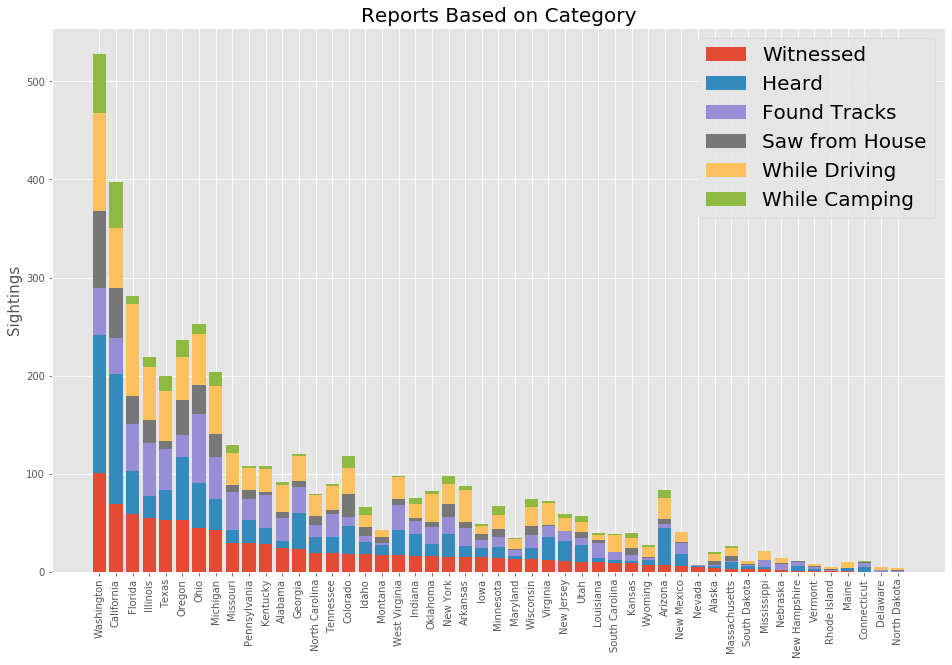

In [267]:
fig, ax = plt.subplots(figsize=(16,10))

ax.bar(states.columns, states.iloc[0].values)

for idx, lab in enumerate(labels[1:]):
    ax.bar(states.columns, states.iloc[idx+1].values, bottom=cumstates[idx])
    
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
title = 'Reports Based on Category'
ax.set_title(title, fontsize=20)
ax.set_ylabel('Sightings', fontsize=15)
ax.legend(labels, fontsize=20)

fig.savefig('../images/labels_all_er.png', bbox_inches='tight')

In [260]:
states = pd.DataFrame()

for i in range(len(labels)):
    add = data[data['label_NMF'] == labels[i]]['STATE'].value_counts(dropna=False)
    add_df = pd.DataFrame(data=add.values.reshape(1,-1), columns=add.index.values, index=[labels[i]])
    states = states.append(add_df)
    
states = states.fillna(0)
states = states.drop(columns=np.nan)

In [261]:
cumstates = np.cumsum(states.values, axis=0)
cumstates

array([[101.,  69.,  59.,  55.,  53.,  53.,  45.,  42.,  29.,  29.,  28.,
         24.,  23.,  19.,  19.,  18.,  18.,  17.,  17.,  16.,  16.,  15.,
         15.,  15.,  14.,  13.,  13.,  12.,  11.,  10.,  10.,   9.,   9.,
          7.,   7.,   6.,   5.,   4.,   3.,   3.,   3.,   2.,   1.,   1.,
          1.,   1.,   0.,   0.,   0.],
       [241., 202., 103.,  77.,  83., 117.,  90.,  74.,  42.,  53.,  45.,
         31.,  60.,  35.,  35.,  47.,  30.,  27.,  43.,  38.,  28.,  38.,
         26.,  24.,  25.,  16.,  24.,  35.,  31.,  27.,  14.,  12.,  11.,
         12.,  45.,  18.,   6.,   6.,  10.,   6.,   5.,   2.,   6.,   3.,
          1.,   4.,   5.,   0.,   0.],
       [289., 238., 151., 131., 125., 139., 161., 117.,  81.,  74.,  78.,
         55.,  86.,  48.,  59.,  56.,  36.,  29.,  68.,  52.,  46.,  56.,
         45.,  32.,  35.,  22.,  37.,  47.,  41.,  34.,  29.,  20.,  17.,
         14.,  49.,  29.,   7.,   7.,  11.,   7.,  12.,   8.,  10.,   5.,
          2.,   4.,   9.,   2.,   

In [256]:
states.index

Index(['Witnessed', 'Heard', 'Found Tracks', 'Saw from House', 'While Driving',
       'While Camping'],
      dtype='object')